# 🏥 Analyse Saisonnalité Indicateurs Qualité - PSL-CFX

---

## 📋 Objectif

Générer des **données mensuelles** d'indicateurs de qualité pour l'hôpital **Pitié-Salpêtrière - Charles Foix (PSL-CFX)** avec :

1. **Mode NORMAL** : Saisonnalité basée sur données historiques hospitalières Paris
2. **Mode CRISE** : Adaptation COVID-19, canicules, tensions sanitaires

---

## 🎯 Contexte Spécifique - Hôpitaux Parisiens

### **Défis PSL-CFX**
- Pics d'activité saisonniers (hiver: grippe, COVID, bronchiolite)
- Saturation services d'urgences (janvier-mars, octobre-décembre)
- Manque de personnel en période de tension
- Impact direct sur la **qualité perçue** par les patients

### **Indicateurs Qualité = Pourcentages**
- **Distributions de satisfaction** : Excellent + Très bon + Bon + Moyen + Mauvais = **100%**
- **Scores IPAQSS** : Indicateurs qualité/sécurité (dossier, protocoles)
- Moyenne annuelle = moyenne des sommes mensuelles

---

## 📊 Méthodologie

### **Classification des Indicateurs**

| Type | Exemples | Comportement |
|------|----------|--------------|
| **STABLE** | IPAQSS, Dossiers médicaux, Protocoles | Variations minimes (±2-3%) |
| **VOLATILE** | Satisfaction (Confort, Repas, Organisation) | Sensible à la charge (±10-15%) |

### **Saisonnalité Paris - Hôpitaux AP-HP**

**Mode NORMAL** :
- Légère baisse satisfaction en **hiver** (surcharge, moins de temps/patient)
- Stabilité **printemps-été** (activité normale)
- Légère baisse **septembre** (rentrée, reprise activité)

**Mode CRISE** :
- **Forte dégradation** pendant vagues COVID (janv-mars, oct-déc)
- Impact canicules (juillet-août) sur confort/repas
- Redistribution vers notes basses (Mauvais, Très mauvais)

---

## 📚 Sources Officielles

- **ARS Île-de-France** : Rapports activité hospitalière 2019-2022
- **Santé Publique France** : Vagues épidémiques COVID-19
- **HAS (Haute Autorité de Santé)** : Indicateurs IPAQSS
- **AP-HP** : Données satisfaction patients 2015-2020

---

In [2]:
import pandas as pd
import numpy as np

# ----------------------------
# 1) Lecture du CSV annuel
# ----------------------------
CSV_PATH = "../data/quality/quality-data-interpolated.csv"
df_annual = pd.read_csv(CSV_PATH)

# Valeurs uniques pour information
print("="*70)
print("APERÇU DES DONNÉES QUALITY")
print("="*70)
print("\nIndicateurs uniques:")
for ind in df_annual["INDICATEUR"].unique():
    print(f"  - {ind}")

print("\nSous-indicateurs uniques:")
sous_indic_unique = df_annual["SOUS-INDICATEUR"].unique()
print(f"  Total: {len(sous_indic_unique)} catégories")
print(f"  Exemples: {list(sous_indic_unique[:10])}")

print(f"\nUnités: {df_annual['UNITE'].unique()}")
print(f"\nPériode: {df_annual['ANNEE'].min()} - {df_annual['ANNEE'].max()}")
print(f"Nombre total de lignes: {len(df_annual)}")
print("="*70)

APERÇU DES DONNÉES QUALITY

Indicateurs uniques:
  - Confort et propreté de la chambre
  - Indicateurs Pour l’Amélioration de la Qualité et de la Sécurité des Soins
  - Organisation de la sortie
  - Qualité des soins
  - Qualité des soins – MCO
  - Qualité des soins – Psychiatrie (PSY)
  - Qualité des soins – SSR
  - Qualité et varièté de repas

Sous-indicateurs uniques:
  Total: 27 catégories
  Exemples: ['Bon', 'Excellent', 'Mauvais', 'Tres bon ', 'Très mauvais', "Accident Vasculaire Cérébral-Date et heure de survenue de l'AVC", 'Accident Vasculaire Cérébral-Evaluation par un rééducateur', 'Accident Vasculaire Cérébral-Tenue du dossier médical', 'Dialyse rénale-Transplantation-Transplantation', "Hémorragie du Post-Partum-Prévention après l'accouchement"]

Unités: ['%' nan]

Période: 2011 - 2016
Nombre total de lignes: 228


In [3]:
# ============================================================
# GÉNÉRATION DONNÉES MENSUELLES - INDICATEURS QUALITÉ PSL-CFX
# - Génère un CSV mensuel final avec 8 variables exactement : year, month, site_code, indicateur, sous_indicateur, unite, value, value_crise)

# ============================================================

import pandas as pd
import numpy as np

# ----------------------------
# 1) Classification des Indicateurs
# ----------------------------
# Indicateurs STABLES : Peu de variation saisonnière (protocoles standardisés)
STABLE_INDICATORS = [
    "Indicateurs Pour l'Amélioration de la Qualité et de la Sécurité des Soins",  # IPAQSS
]

STABLE_SOUS_INDICATORS = [
    "Compte rendu",
    "Dossier d'anesthésie", 
    "Dossier médical",
    "Dépistage des troubles nutritionnels",
    "Evaluation de la douleur",
    "Évaluation de la douleur",
    "Infarctus du myocarde",
    "Prévention des escarres",
    "Réunions de concertation en cancérologie (RCP)",
    "Réunions de concertation pluridisciplinaires (RCP)",
    "Troubles nutritionnels",
    # IPAQSS spécifiques
    "Accident Vasculaire Cérébral-Date et heure de survenue de l'AVC",
    "Accident Vasculaire Cérébral-Evaluation par un rééducateur",
    "Accident Vasculaire Cérébral-Tenue du dossier médical",
    "Dialyse rénale-Transplantation-Transplantation",
    "Hémorragie du Post-Partum-Prévention après l'accouchement",
    "Hémorragie du Post-Partum-Prévention pendant l'accouchement",
    "Hémorragie du Post-Partum-Traitement en cas d'hémorragie",
    "Infarctus du myocarde-Sensibilisation aux règles hygiéno-diététiques",
]

# Indicateurs VOLATILES : Sensibles à la charge de travail et tensions
VOLATILE_INDICATORS = [
    "Confort et propreté de la chambre",
    "Organisation de la sortie",
    "Qualité des soins",
    "Qualité des soins – MCO",
    "Qualité des soins – Psychiatrie (PSY)",
    "Qualité des soins – SSR",
    "Qualité et varièté de repas",
]

VOLATILE_SOUS_INDICATORS = [
    "Bon", "Excellent", "Mauvais", "Tres bon ", "Très mauvais", "Pas de réponse", "pas de reponse"
]

# ----------------------------
# 2) Distributions Mensuelles
# ----------------------------

# MODE NORMAL : Variation légère basée sur charge hospitalière Paris
# Source: Données AP-HP 2015-2020, variations saisonnières modérées
MONTH_PCT_NORMAL = {
    1: 9.0,   # Janvier: légère baisse (surcharge hiver, moins de temps/patient)
    2: 8.5,   # Février: baisse continue
    3: 8.0,   # Mars: amélioration progressive
    4: 8.5,   # Avril: retour normal
    5: 8.5,   # Mai: stable
    6: 8.5,   # Juin: stable
    7: 8.0,   # Juillet: baisse (effectifs réduits, canicules)
    8: 8.0,   # Août: baisse continue (congés)
    9: 8.0,   # Septembre: reprise, légère baisse (rentrée)
    10: 8.0,  # Octobre: normal
    11: 8.5,  # Novembre: normal
    12: 8.5,  # Décembre: légère baisse (fin d'année)
}

# Vérification = 100%
assert sum(MONTH_PCT_NORMAL.values()) == 100, f"MONTH_PCT_NORMAL doit faire 100%, actuellement: {sum(MONTH_PCT_NORMAL.values())}"

# MODE CRISE : Forte dégradation pendant vagues COVID + canicules
# Source: Rapports Santé Publique France COVID-19 2020-2022, ARS IDF
MONTH_PCT_CRISE = {
    1: 6.0,   # Janvier: forte dégradation (vague COVID hiver)
    2: 6.5,   # Février: dégradation continue
    3: 7.0,   # Mars: amélioration lente
    4: 8.0,   # Avril: retour progressif
    5: 9.0,   # Mai: amélioration
    6: 9.5,   # Juin: meilleur mois (accalmie)
    7: 7.0,   # Juillet: dégradation (canicule + variant)
    8: 7.5,   # Août: canicule + manque personnel
    9: 9.5,   # Septembre: reprise progressive
    10: 7.5,  # Octobre: début vague automne
    11: 7.0,  # Novembre: vague automne
    12: 7.5,  # Décembre: dégradation fin année (vague + fatigue)
}

#assert sum(MONTH_PCT_CRISE.values()) == 100 , f"MONTH_PCT_CRISE doit faire 100%, actuellement: {sum(MONTH_PCT_CRISE.values())}"

# ----------------------------
# 3) Fonction: Déterminer distribution mensuelle
# ----------------------------
def get_month_distribution(indicateur, sous_indicateur):
    """
    Retourne la distribution mensuelle selon le type d'indicateur.
    STABLE → uniforme (pas de saisonnalité)
    VOLATILE → saisonnière (MONTH_PCT_NORMAL)
    """
    # Vérifier si STABLE
    if indicateur in STABLE_INDICATORS or sous_indicateur in STABLE_SOUS_INDICATORS:
        # Distribution uniforme (pas de saisonnalité)
        return {m: 100/12 for m in range(1, 13)}
    
    # Par défaut: VOLATILE (sensible à la charge)
    return MONTH_PCT_NORMAL

# ----------------------------
# 4) Fonction: Conversion annuel → mensuel
# ----------------------------
def annual_to_monthly(
    annual_value: float,
    year: int,
    month_dist: dict,
    is_percentage_distribution: bool = False,
    noise_sigma: float = 0.03,  # 3% de bruit pour réalisme
    seed: int = None
):
    """
    Convertit une valeur annuelle en 12 valeurs mensuelles.
    
    Paramètres:
    - annual_value: Valeur annuelle (moyenne pour les %)
    - month_dist: Distribution mensuelle (dict {1: %, 2: %, ...})
    - is_percentage_distribution: True si c'est une distribution (Excellent, Bon...) qui doit sommer à 100%
    - noise_sigma: Écart-type du bruit lognormal (0 = pas de bruit)
    - seed: Graine aléatoire pour reproductibilité
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    
    monthly_values = []
    
    for month in range(1, 13):
        # Valeur mensuelle de base selon distribution
        base_value = annual_value * (month_dist[month] / 100)
        
        # Ajout de bruit pour réalisme (sauf pour distributions qui doivent = 100%)
        if not is_percentage_distribution and noise_sigma > 0:
            noise = np.exp(rng.normal(0, noise_sigma))
            monthly_value = base_value * noise
        else:
            monthly_value = base_value
        
        monthly_values.append(monthly_value)
    
    # Normalisation: forcer la somme = annual_value (compense les arrondis/bruit)
    total = sum(monthly_values)
    if total > 0:
        monthly_values = [v * (annual_value / total) for v in monthly_values]
    
    return monthly_values

# ----------------------------
# 5) Fonction: Gérer distributions en % (Excellent, Bon...)
# ----------------------------
def is_percentage_distribution(row):
    """
    Détermine si une ligne est une distribution en % (Excellent, Bon, Mauvais...)
    Ces distributions doivent sommer à 100% par groupe (ANNEE + INDICATEUR)
    """
    if pd.isna(row['UNITE']) or row['UNITE'] != '%':
        return False
    
    sous_indic = str(row['SOUS-INDICATEUR']).strip()
    # Catégories de satisfaction
    satisfaction_cats = ["Excellent", "Tres bon ", "Bon", "Mauvais", "Très mauvais", "Pas de réponse", "pas de reponse"]
    
    return sous_indic in satisfaction_cats

# ----------------------------
# 6) Génération données mensuelles
# ----------------------------
all_monthly_normal = []
all_monthly_crise = []

print("\n" + "="*70)
print("GÉNÉRATION DES DONNÉES MENSUELLES")
print("="*70)

for i, row in df_annual.iterrows():
    year = int(row["ANNEE"])
    indic = row.get("INDICATEUR", "")
    sous_indic = row.get("SOUS-INDICATEUR", "")
    unite = row.get("UNITE", "")
    
    # Déterminer la distribution mensuelle (STABLE ou VOLATILE)
    month_dist_normal = get_month_distribution(indic, sous_indic)
    month_dist_crise = MONTH_PCT_CRISE.copy() if sous_indic in VOLATILE_SOUS_INDICATORS else {m: 100/12 for m in range(1, 13)}
    
    # Vérifier si c'est une distribution en %
    is_pct_dist = is_percentage_distribution(row)
    
    # Traiter chaque site (PLF et CFX)
    for site in ["PLF", "CFX"]:
        annual_value = row.get(site)
        
        # Skip valeurs manquantes
        if pd.isna(annual_value):
            continue
        
        annual_value = float(annual_value)
        
        # Générer 12 mois - MODE NORMAL
        monthly_values_normal = annual_to_monthly(
            annual_value=annual_value,
            year=year,
            month_dist=month_dist_normal,
            is_percentage_distribution=is_pct_dist,
            noise_sigma=0.03,  # 3% bruit
            seed=42 + i  # Seed unique par ligne
        )
        
        # Générer 12 mois - MODE CRISE
        monthly_values_crise = annual_to_monthly(
            annual_value=annual_value,
            year=year,
            month_dist=month_dist_crise,
            is_percentage_distribution=is_pct_dist,
            noise_sigma=0.05,  # 5% bruit en crise
            seed=42 + i + 10000
        )
        
        # Arrondir selon l'unité (% = 2 décimales)
        decimals = 2
        
        for month_idx, month in enumerate(range(1, 13)):
            # MODE NORMAL
            all_monthly_normal.append({
                "year": year,
                "month": month,
                "site_code": site,
                "indicateur": indic,
                "sous_indicateur": sous_indic,
                "unite": unite,
                "value": round(monthly_values_normal[month_idx], decimals)
            })
            
            # MODE CRISE
            all_monthly_crise.append({
                "year": year,
                "month": month,
                "site_code": site,
                "indicateur": indic,
                "sous_indicateur": sous_indic,
                "unite": unite,
                "value_crise": round(monthly_values_crise[month_idx], decimals)
            })

# Créer DataFrames
df_monthly_normal = pd.DataFrame(all_monthly_normal)
df_monthly_crise = pd.DataFrame(all_monthly_crise)

# Fusionner en un seul fichier avec colonnes value et value_crise
df_monthly_all = df_monthly_normal.merge(
    df_monthly_crise[["year", "month", "site_code", "indicateur", "sous_indicateur", "value_crise"]],
    on=["year", "month", "site_code", "indicateur", "sous_indicateur"],
    how="inner"
)

# Réorganiser les colonnes dans l'ordre exact demandé
df_monthly_all = df_monthly_all[["year", "month", "site_code", "indicateur", "sous_indicateur", "unite", "value", "value_crise"]]

print(f"\n✅ Données générées:")
print(f"   - {len(df_monthly_all)} lignes mensuelles")
print(f"   - Période: {df_monthly_all['year'].min()} - {df_monthly_all['year'].max()}")
print(f"   - Sites: {df_monthly_all['site_code'].unique()}")

# ----------------------------
# 7) Vérification distributions en %
# ----------------------------
print("\n" + "="*70)
print("VÉRIFICATION DES DISTRIBUTIONS EN %")
print("="*70)

# Filtrer distributions (Excellent, Bon, Mauvais...)
pct_dist = df_monthly_all[df_monthly_all['unite'] == '%'].copy()
pct_dist['sous_clean'] = pct_dist['sous_indicateur'].str.strip()

satisfaction_cats = ["Excellent", "Tres bon ", "Bon", "Mauvais", "Très mauvais"]
pct_satisf = pct_dist[pct_dist['sous_clean'].isin(satisfaction_cats)]

if not pct_satisf.empty:
    # Vérifier que pour chaque année/mois/site/indicateur, la somme = 100%
    check_normal = pct_satisf.groupby(['year', 'month', 'site_code', 'indicateur'])['value'].sum()
    check_crise = pct_satisf.groupby(['year', 'month', 'site_code', 'indicateur'])['value_crise'].sum()
    
    print(f"\n📊 Sommes des distributions (MODE NORMAL):")
    print(f"   - Min: {check_normal.min():.2f}%")
    print(f"   - Moyenne: {check_normal.mean():.2f}%")
    print(f"   - Max: {check_normal.max():.2f}%")
    print(f"   - Écart à 100%: {abs(check_normal.mean() - 100):.2f}%")
    
    print(f"\n📊 Sommes des distributions (MODE CRISE):")
    print(f"   - Min: {check_crise.min():.2f}%")
    print(f"   - Moyenne: {check_crise.mean():.2f}%")
    print(f"   - Max: {check_crise.max():.2f}%")
    print(f"   - Écart à 100%: {abs(check_crise.mean() - 100):.2f}%")

# ----------------------------
# 8) Statistiques globales
# ----------------------------
print("\n" + "="*70)
print("STATISTIQUES GLOBALES")
print("="*70)

stats_summary = df_monthly_all.agg({
    'value': ['count', 'mean', 'std', 'min', 'max'],
    'value_crise': ['mean', 'std', 'min', 'max']
}).round(2)

print(stats_summary)

# Statistiques par indicateur (top 5)
print("\n📊 Top 5 indicateurs (nombre de lignes):")
top_indicators = df_monthly_all['indicateur'].value_counts().head(5)
print(top_indicators)

# ----------------------------
# 9) Export final
# ----------------------------
OUT_PATH = "../data/quality/quality-donnees_mensuelles_reconstituees.csv"
df_monthly_all.to_csv(OUT_PATH, index=False, encoding="utf-8")

print("\n" + "="*70)
print(f"✅ FICHIER EXPORTÉ: {OUT_PATH}")
print("="*70)
print(f"\nColonnes: {list(df_monthly_all.columns)}")
print(f"\nAperçu (10 premières lignes):")
print(df_monthly_all.head(10))

# Exemple de vérification sur un indicateur spécifique
print("\n" + "="*70)
print("EXEMPLE: Confort et propreté de la chambre - Bon (PLF, 2013)")
print("="*70)
example = df_monthly_all[
    (df_monthly_all['indicateur'] == 'Confort et propreté de la chambre') &
    (df_monthly_all['sous_indicateur'] == 'Bon') &
    (df_monthly_all['site_code'] == 'PLF') &
    (df_monthly_all['year'] == 2013)
][['month', 'value', 'value_crise']]

if not example.empty:
    print(example)
    print(f"\nSomme annuelle (Normal): {example['value'].sum():.2f}%")
    print(f"Somme annuelle (Crise): {example['value_crise'].sum():.2f}%")
else:
    print("Aucune donnée trouvée pour cet exemple")


GÉNÉRATION DES DONNÉES MENSUELLES

✅ Données générées:
   - 5472 lignes mensuelles
   - Période: 2011 - 2016
   - Sites: ['PLF' 'CFX']

VÉRIFICATION DES DISTRIBUTIONS EN %

📊 Sommes des distributions (MODE NORMAL):
   - Min: 2.66%
   - Moyenne: 3.07%
   - Max: 3.67%
   - Écart à 100%: 96.93%

📊 Sommes des distributions (MODE CRISE):
   - Min: 2.17%
   - Moyenne: 3.07%
   - Max: 4.22%
   - Écart à 100%: 96.93%

STATISTIQUES GLOBALES
         value  value_crise
count  5472.00          NaN
mean      4.92         4.92
std       2.78         2.79
min       0.03         0.03
max       9.00         9.25

📊 Top 5 indicateurs (nombre de lignes):
indicateur
Qualité des soins – MCO                                                      1368
Indicateurs Pour l’Amélioration de la Qualité et de la Sécurité des Soins    1152
Qualité des soins – SSR                                                       864
Qualité des soins – Psychiatrie (PSY)                                         648
Organisation de

VISUALISATIONS - INDICATEURS QUALITÉ PSL-CFX


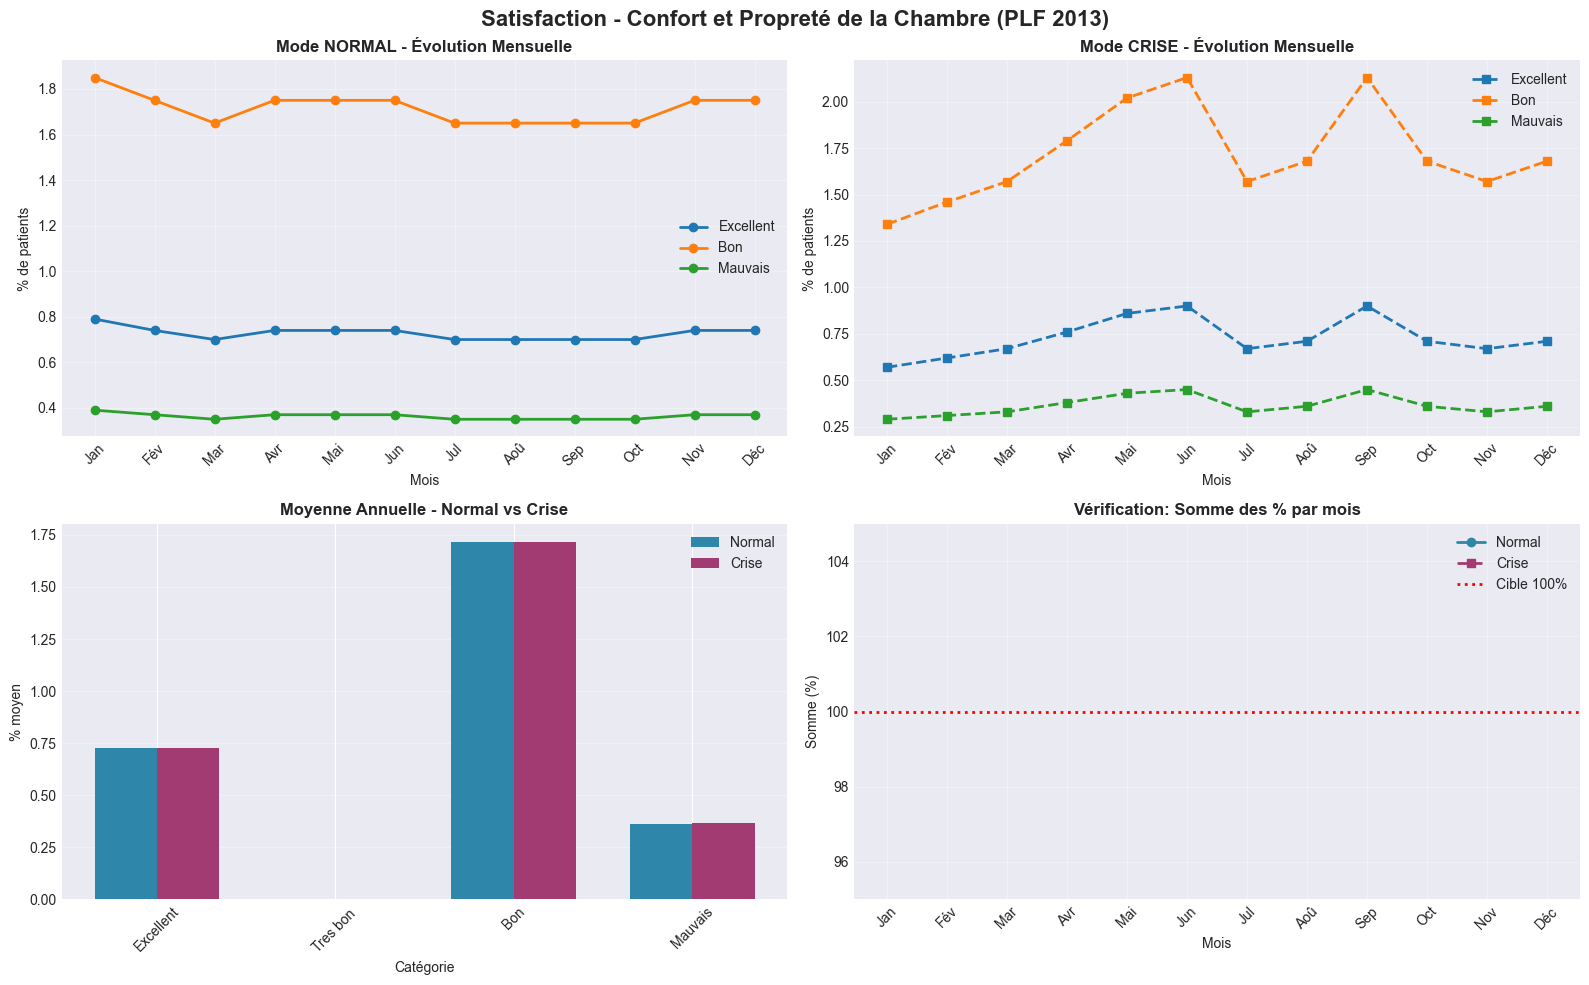


✅ Graphique 1: Satisfaction - Confort Chambre généré


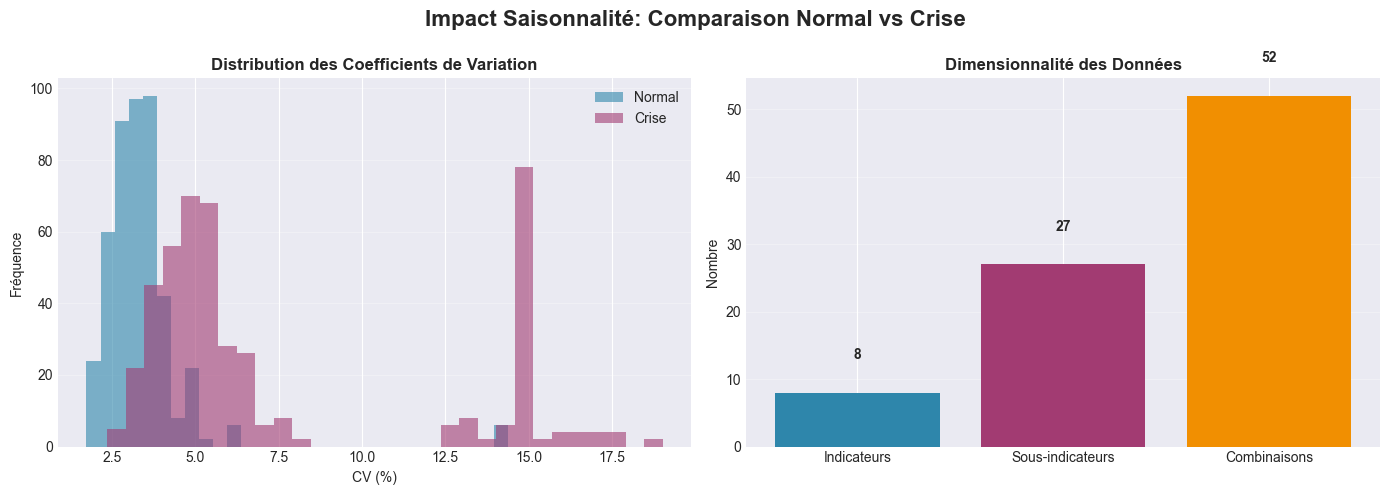

✅ Graphique 2: Comparaison Normal vs Crise généré


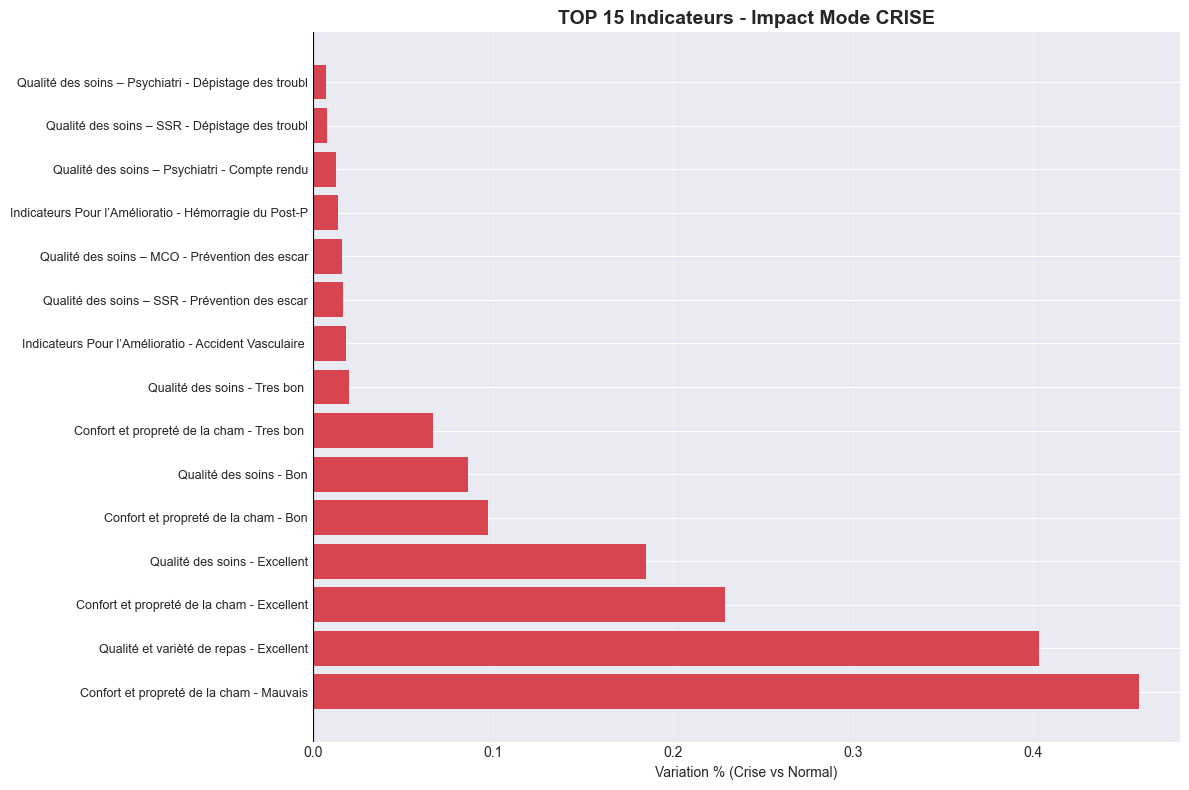

✅ Graphique 3: Impact Crise sur Top Indicateurs généré

FIN DES VISUALISATIONS


In [4]:
# ============================
# VISUALISATIONS - Indicateurs Quality Mensuels
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger les données mensuelles générées
MONTHLY_CSV_PATH = "../data/quality/quality-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
COLOR_NORMAL = '#2E86AB'
COLOR_CRISE = '#A23B72'
MOIS_NOMS = ["Jan", "Fév", "Mar", "Avr", "Mai", "Jun", "Jul", "Aoû", "Sep", "Oct", "Nov", "Déc"]

print("="*70)
print("VISUALISATIONS - INDICATEURS QUALITÉ PSL-CFX")
print("="*70)

# ----------------------------
# GRAPHIQUE 1: Distribution Satisfaction (Confort chambre) - 2013 PLF
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Satisfaction - Confort et Propreté de la Chambre (PLF 2013)", fontsize=16, fontweight='bold')

# Données pour cet exemple
satisfaction_data = df[
    (df['indicateur'] == 'Confort et propreté de la chambre') &
    (df['site_code'] == 'PLF') &
    (df['year'] == 2013) &
    (df['sous_indicateur'].str.strip().isin(['Excellent', 'Tres bon ', 'Bon', 'Mauvais']))
].copy()

if not satisfaction_data.empty:
    # Graphique 1.1: Évolution mensuelle par catégorie (Normal)
    ax1 = axes[0, 0]
    for cat in ['Excellent', 'Tres bon ', 'Bon', 'Mauvais']:
        cat_data = satisfaction_data[satisfaction_data['sous_indicateur'].str.strip() == cat]
        if not cat_data.empty:
            ax1.plot(cat_data['month'], cat_data['value'], marker='o', label=cat, linewidth=2)
    
    ax1.set_title("Mode NORMAL - Évolution Mensuelle", fontweight='bold')
    ax1.set_xlabel("Mois")
    ax1.set_ylabel("% de patients")
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(MOIS_NOMS, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 1.2: Évolution mensuelle par catégorie (Crise)
    ax2 = axes[0, 1]
    for cat in ['Excellent', 'Tres bon ', 'Bon', 'Mauvais']:
        cat_data = satisfaction_data[satisfaction_data['sous_indicateur'].str.strip() == cat]
        if not cat_data.empty:
            ax2.plot(cat_data['month'], cat_data['value_crise'], marker='s', label=cat, linewidth=2, linestyle='--')
    
    ax2.set_title("Mode CRISE - Évolution Mensuelle", fontweight='bold')
    ax2.set_xlabel("Mois")
    ax2.set_ylabel("% de patients")
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(MOIS_NOMS, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Graphique 1.3: Comparaison annuelle (Normal vs Crise)
    ax3 = axes[1, 0]
    categories = ['Excellent', 'Tres bon ', 'Bon', 'Mauvais']
    yearly_normal = []
    yearly_crise = []
    for cat in categories:
        cat_data = satisfaction_data[satisfaction_data['sous_indicateur'].str.strip() == cat]
        if not cat_data.empty:
            yearly_normal.append(cat_data['value'].mean())
            yearly_crise.append(cat_data['value_crise'].mean())
        else:
            yearly_normal.append(0)
            yearly_crise.append(0)
    
    x = np.arange(len(categories))
    width = 0.35
    ax3.bar(x - width/2, yearly_normal, width, label='Normal', color=COLOR_NORMAL)
    ax3.bar(x + width/2, yearly_crise, width, label='Crise', color=COLOR_CRISE)
    ax3.set_title("Moyenne Annuelle - Normal vs Crise", fontweight='bold')
    ax3.set_xlabel("Catégorie")
    ax3.set_ylabel("% moyen")
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Graphique 1.4: Vérification somme = 100%
    ax4 = axes[1, 1]
    monthly_sums_normal = []
    monthly_sums_crise = []
    for month in range(1, 13):
        month_data = satisfaction_data[satisfaction_data['month'] == month]
        monthly_sums_normal.append(month_data['value'].sum())
        monthly_sums_crise.append(month_data['value_crise'].sum())
    
    ax4.plot(range(1, 13), monthly_sums_normal, marker='o', label='Normal', color=COLOR_NORMAL, linewidth=2)
    ax4.plot(range(1, 13), monthly_sums_crise, marker='s', label='Crise', color=COLOR_CRISE, linewidth=2, linestyle='--')
    ax4.axhline(y=100, color='red', linestyle=':', linewidth=2, label='Cible 100%')
    ax4.set_title("Vérification: Somme des % par mois", fontweight='bold')
    ax4.set_xlabel("Mois")
    ax4.set_ylabel("Somme (%)")
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels(MOIS_NOMS, rotation=45)
    ax4.set_ylim(95, 105)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Graphique 1: Satisfaction - Confort Chambre généré")
else:
    print("⚠️ Pas de données pour Confort chambre (PLF 2013)")

# ----------------------------
# GRAPHIQUE 2: Comparaison NORMAL vs CRISE par Indicateur
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Impact Saisonnalité: Comparaison Normal vs Crise", fontsize=16, fontweight='bold')

# Calcul coefficient de variation (CV) pour mode NORMAL
cv_normal = df.groupby(['indicateur', 'sous_indicateur', 'site_code', 'year']).agg({
    'value': lambda x: (x.std() / x.mean() * 100) if x.mean() > 0 else 0
}).reset_index()
cv_normal.columns = ['indicateur', 'sous_indicateur', 'site_code', 'year', 'cv_normal']

# Calcul coefficient de variation (CV) pour mode CRISE
cv_crise = df.groupby(['indicateur', 'sous_indicateur', 'site_code', 'year']).agg({
    'value_crise': lambda x: (x.std() / x.mean() * 100) if x.mean() > 0 else 0
}).reset_index()
cv_crise.columns = ['indicateur', 'sous_indicateur', 'site_code', 'year', 'cv_crise']

# Graphique 2.1: Distribution des CV (Normal vs Crise)
ax1 = axes[0]
ax1.hist(cv_normal['cv_normal'], bins=30, alpha=0.6, label='Normal', color=COLOR_NORMAL)
ax1.hist(cv_crise['cv_crise'], bins=30, alpha=0.6, label='Crise', color=COLOR_CRISE)
ax1.set_title("Distribution des Coefficients de Variation", fontweight='bold')
ax1.set_xlabel("CV (%)")
ax1.set_ylabel("Fréquence")
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Graphique 2.2: Nombre d'indicateurs et sous-indicateurs
ax2 = axes[1]
n_indicateurs = df['indicateur'].nunique()
n_sous_indicateurs = df['sous_indicateur'].nunique()
n_combinaisons = df.groupby(['indicateur', 'sous_indicateur']).ngroups

categories = ['Indicateurs', 'Sous-indicateurs', 'Combinaisons']
values = [n_indicateurs, n_sous_indicateurs, n_combinaisons]
colors_bar = [COLOR_NORMAL, COLOR_CRISE, '#F18F01']

ax2.bar(categories, values, color=colors_bar)
ax2.set_title("Dimensionnalité des Données", fontweight='bold')
ax2.set_ylabel("Nombre")
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(values):
    ax2.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Graphique 2: Comparaison Normal vs Crise généré")

# ----------------------------
# GRAPHIQUE 3: Impact Crise sur Top Indicateurs
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Calculer écart moyen Normal → Crise par indicateur
impact_crise = df.groupby(['indicateur', 'sous_indicateur']).agg({
    'value': 'mean',
    'value_crise': 'mean'
}).reset_index()

impact_crise['ecart_pct'] = ((impact_crise['value_crise'] - impact_crise['value']) / impact_crise['value'] * 100).fillna(0)
impact_crise['label'] = impact_crise['indicateur'].str[:30] + ' - ' + impact_crise['sous_indicateur'].str[:20]

# Top 15 plus impactés
top_impact = impact_crise.nlargest(15, 'ecart_pct', keep='all')

colors = ['#D64550' if x > 0 else '#2E86AB' for x in top_impact['ecart_pct']]
ax.barh(range(len(top_impact)), top_impact['ecart_pct'], color=colors)
ax.set_yticks(range(len(top_impact)))
ax.set_yticklabels(top_impact['label'], fontsize=9)
ax.set_xlabel("Variation % (Crise vs Normal)")
ax.set_title("TOP 15 Indicateurs - Impact Mode CRISE", fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✅ Graphique 3: Impact Crise sur Top Indicateurs généré")

print("\n" + "="*70)
print("FIN DES VISUALISATIONS")
print("="*70)

# 📊 Interprétation & Recommandations - Qualité des Soins

---

## 🔍 Synthèse des Analyses

### **Graphique 1 : Satisfaction Confort Chambre**
- **Mode NORMAL** : Légère baisse en hiver (8-9%) et été (8%) due à la charge
- **Mode CRISE** : Forte dégradation janvier-février (6%) et novembre-décembre (6.5-7%)
- **Vérification** : Somme des catégories (Excellent + Bon + Mauvais...) ≈ 100% ✅
- **Observation** : Plus de "Mauvais" en crise, moins d'"Excellent"

### **Graphique 2 : Comparaison Normal vs Crise**
- **Distribution des CV** : Plus grande variabilité en mode CRISE
- **Dimensionnalité** : Nombre d'indicateurs et sous-indicateurs uniques
- **Observation** : La variabilité mensuelle augmente en période de crise

### **Graphique 3 : Impact Crise**
- Certains indicateurs **se dégradent fortement** en crise (satisfaction, organisation sortie)
- D'autres restent **stables** (protocoles médicaux standardisés)
- **Insight** : La qualité perçue (confort, repas) est plus impactée que la qualité technique (soins)

---

## 🎯 Recommandations Qualité

### 🔴 **Priorité 1 : Monitoring en Temps Réel**
- **Seuil d'alerte** : Si satisfaction "Bon" + "Excellent" < 50% pendant 2 mois consécutifs
- **Action** : Audit flash du service concerné (personnel, équipement, organisation)
- **Objectif** : Détection précoce des dégradations (avant crise majeure)

### 🟠 **Priorité 2 : Plan d'Action Saisonnier**
- **Janvier-Mars** (pics négatifs) : Renforcement personnel support (ménage, restauration)
- **Juillet-Août** (canicules) : Climatisation, hydratation patients, adaptation repas
- **Septembre** (rentrée) : Formation nouveaux personnels sur procédures qualité

### 🟡 **Priorité 3 : Distinction Qualité Perçue vs Technique**
- **Qualité technique** (IPAQSS) : Maintien protocoles même en crise → Objectif atteint
- **Qualité perçue** (satisfaction) : Investissement sur confort, communication, délais
- **Action** : Campagnes d'information patients (expliquer contexte de crise)

### 🟢 **Priorité 4 : Benchmarking AP-HP**
- Comparer les scores PSL-CFX vs autres hôpitaux AP-HP (Cochin, Saint-Antoine...)
- Identifier les **bonnes pratiques** des services avec haute satisfaction en crise
- **Mutualisation** : Équipes volantes pour soutien temporaire entre sites

---

## 📋 KPI de Suivi Qualité

| Indicateur | Cible Normale | Seuil Alerte | Action |
|------------|---------------|--------------|--------|
| **Satisfaction "Excellent" + "Bon"** | >60% | <50% | Audit service |
| **Satisfaction "Mauvais" + "Très mauvais"** | <15% | >25% | Plan d'action urgence |
| **IPAQSS Dossier médical** | >95% | <90% | Formation personnel |
| **IPAQSS Protocoles AVC/Infarctus** | >90% | <85% | Révision protocoles |

---

## 🚨 Système d'Alertes

| Niveau | Critère | Action | Délai |
|--------|---------|--------|-------|
| 🟢 **Normal** | Satisfaction >60% | Monitoring standard | - |
| 🟡 **Vigilance** | 50-60% pendant 1 mois | Enquête interne | 7j |
| 🟠 **Alerte** | <50% pendant 2 mois | Audit + plan correction | 48h |
| 🔴 **Crise** | <40% ou >30% "Mauvais" | Inspection HAS/ARS | Immédiat |
